In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

In [2]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, e...",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beaut...,weather
7,The dog is lazy but the brown fox is quick!,animals


In [3]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):

    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()

    tokens = wpt.tokenize(doc)

    filtered_tokens = [token for token in tokens if token not in stop_words]

    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [6]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

In [7]:
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


In [9]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


In [10]:
from keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(bible (5766), king (13)) -> 1
(king (13), james (1154)) -> 1
(king (13), jaanai (9733)) -> 0
(bible (5766), berothai (9376)) -> 0
(bible (5766), james (1154)) -> 1
(james (1154), hagarites (6229)) -> 0
(king (13), paphos (8273)) -> 0
(king (13), bible (5766)) -> 1
(james (1154), king (13)) -> 1
(bible (5766), eunuchs (2184)) -> 0


In [11]:
from keras.layers import concatenate
from keras.layers.core import Dense, Reshape
from keras.layers import Embedding
from keras.models import Sequential

word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

In [12]:
from keras.models import Model,Sequential 
from keras.layers import *

In [13]:
merged_output = add([word_model.output, context_model.output])  
model_combined = Sequential()
model_combined.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
final_model = Model([word_model.input, context_model.input], model_combined(merged_output))
final_model.compile(loss="mean_squared_error", optimizer="rmsprop")
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_1_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       1242500     ['embedding_input[0][0]']        
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       1242500     ['embedding_1_input[0][0]']      
                                                                                              

In [14]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += final_model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 3645.762237899471
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 3186.7531970618293
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 3113.2282693724846
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 3094.512258207891
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
E

In [15]:
from sklearn.metrics.pairwise import euclidean_distances
word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
shall,-0.053009,-0.146227,0.058036,-0.226856,0.235026,0.142777,0.137965,-0.177101,-0.047031,0.065713,...,0.252381,0.217599,-0.016406,0.261564,-0.053759,0.194547,0.117784,0.075387,-0.352191,0.145583
unto,-0.019623,-0.199403,-0.098762,-0.381436,0.208328,0.132303,0.046782,-0.316051,0.005672,0.089741,...,0.373450,0.329141,0.130133,0.375952,-0.027596,0.122251,0.170339,0.006182,-0.385947,0.266116
lord,0.008022,-0.078684,-0.022262,-0.160712,0.284366,0.130655,-0.024897,-0.096752,-0.014456,0.109056,...,0.098797,0.128454,0.182122,0.226337,0.000694,0.203177,0.252234,0.094137,-0.322787,0.287290
thou,-0.113375,-0.064607,0.091111,-0.130238,0.117375,0.048324,0.074535,-0.062186,0.038441,0.023671,...,0.129852,0.139363,0.071674,0.141616,-0.020044,-0.045455,0.164424,0.045054,-0.248477,0.034606
thy,-0.083568,-0.132911,0.010071,-0.152963,0.148039,0.068339,0.140041,-0.165319,0.036291,0.092020,...,0.182605,0.106512,0.009890,0.163959,-0.070175,-0.025917,0.144809,0.080930,-0.334957,-0.043769


In [16]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(12424, 12424)


{'god': ['said', 'day', 'israel', 'thou', 'upon'],
 'jesus': ['begotten', 'common', 'diligent', 'nought', 'suffered'],
 'noah': ['heber', 'hoglah', 'othniel', 'sunrising', 'ashtaroth'],
 'egypt': ['pharaoh', 'sign', 'forgive', 'found', 'congregation'],
 'john': ['latchet', 'pools', 'ointments', 'aprons', 'healing'],
 'gospel': ['bride', 'prisoner', 'churches', 'immediately', 'shortly'],
 'moses': ['vail', 'command', 'wast', 'owner', 'anointing'],
 'famine': ['locust', 'skins', 'menservants', 'egyptian', 'foursquare']}

Total words: 48 	Word Embedding shapes: (48, 100)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


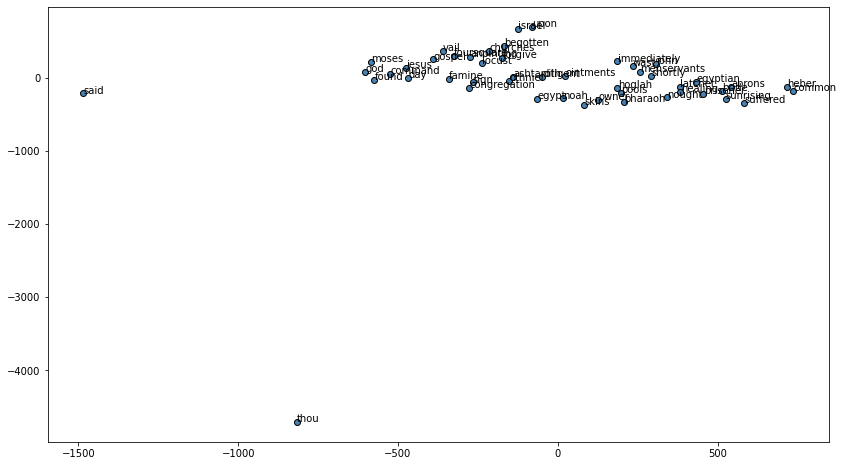

In [17]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')